# Test score fusion and calibration for Speaker Verification (SV)

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
os.chdir('../..')
sys.path.insert(1, os.path.join(sys.path[0], '../..'))

import matplotlib
matplotlib.rc('pdf', fonttype=42)

In [64]:
from notebooks.notebooks_utils import (
    load_models,
    evaluate_models,
    create_metrics_df
)

from sslsv.evaluation.sv_visualization import scores_distribution

from sslsv.evaluation.CosineSVEvaluation import CosineSVEvaluation, CosineSVEvaluationTaskConfig
from sslsv.evaluation.CosineSVEvaluation import SpeakerVerificationEvaluation, SpeakerVerificationEvaluationTaskConfig
from sslsv.evaluation.ScoreCalibration import ScoreCalibration

In [29]:
models = load_models([
    './configs/simclr_ecapa.yml',
    './configs/simclr_ecapa_simo.yml'
])

In [45]:
evals = evaluate_models(models, CosineSVEvaluation, CosineSVEvaluationTaskConfig(), return_evals=True)
create_metrics_df(models)

Extracting test embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████| 74/74 [00:12<00:00,  5.70it/s]


,voxceleb1_test_O/eer,voxceleb1_test_O/mindcf
Model,,
simclr_ecapa,6.8557,0.6059
simclr_ecapa_simo,10.0643,0.6469


In [62]:
class FusedAndCalibratedSVEvaluation(SpeakerVerificationEvaluation):
    
    def __init__(self, evaluations, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.evaluations = evaluations
        self.sc = ScoreCalibration(evaluations)

    def _prepare_evaluation(self):
        self.sc.train()
    
    def _get_sv_score(self, a, b):
        scores = [evaluation._get_sv_score(a, b) for evaluation in self.evaluations]
        score = self.sc.predict(torch.tensor(scores).unsqueeze(0))
        return score.detach().item()

In [68]:
evaluation = FusedAndCalibratedSVEvaluation(
    evaluations=evals,
    model=None,
    config=evals[0].config,
    task_config=SpeakerVerificationEvaluationTaskConfig()
)

models['final'] = {
    'metrics': evaluation.evaluate(),
    'scores': evaluation.scores,
    'targets': evaluation.targets
}

create_metrics_df(models)

,voxceleb1_test_O/eer,voxceleb1_test_O/mindcf
Model,,
simclr_ecapa,6.8557,0.6059
final,6.8822,0.6058
simclr_ecapa_simo,10.0643,0.6469


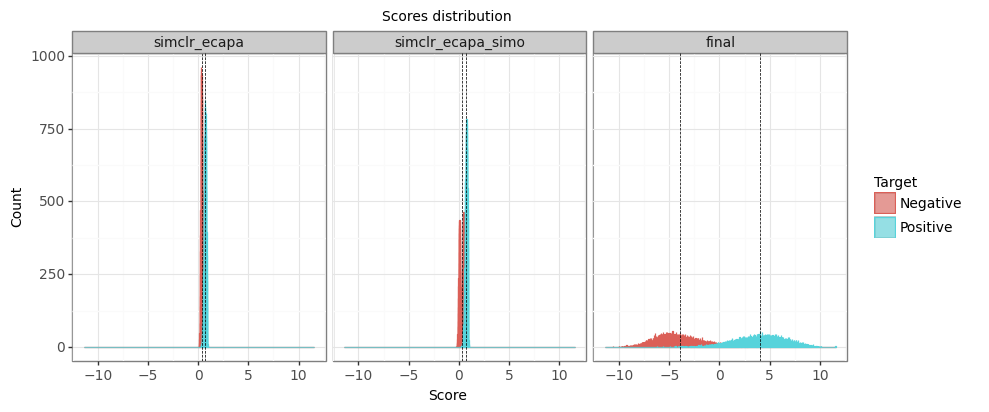

<ggplot: (8736304258781)>

In [69]:
scores_distribution(models, use_angle=False)